# LangGraph

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) 是基于 LangChain 生态的智能体开发框架。它提供了构建任意 Workflow 和 Agent 所需的基础设施。

不同于很多 No-code / Low-code 的开发框架，它不对提示词或架构进行抽象封装，而是直接提供以下几项核心优势：
- **控制（Control）**：开发者可以轻易的定义或组合任意的 workflows 和 agents;
- **持久化（Persistence)**：可以持久化存储图状态（State of Graph)，使开发记忆功能（Memory）和人类干预功能（Human-in-the-loop）成为可能；
- **测试、调试、部署（Testing, Debugging, Deployment）**：容易进行测试、调试、部署。






## 控制（Control)

在 LangGraph 中，LLM应用被定义成一个图，包含：
- 状态（State）：任务执行过程中，所需要的所有信息都会存储在 State 中；
- 节点（Nodes）：需要在哪些节点更新 State 信息；
- 边（Edges）：这些节点是如何连接在一起的。

需要注意的是， State 是 Langgraph 的核心，Nodes 是更新State的节点，Edges是节点流转的路径。

`State` 中定义了我们想在应用程序运行过程中追踪的信息的模型，它可以是 Python 中任何带有 `getattr()` 方法的对象，比如字典、类或者 `Pydantic` 对象：
- `TypeDict` 速度很快，但不支持默认值；
- `Dataclass` 也很快，支持 state.foo 的访问方式，支持默认值；
- `Pydantic` 速度较慢，支持数据验证。

LangGraph 中，使用 `StateGraph` 类来初始化 LangGraph 对象，入参为 `State` 对象。



In [13]:
import sys
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

sys.path.append("..")
from src.agents_intro import model_with_tools, write_email # 导入之前的代码
from src.utils import show_graph

In [8]:
# 使用 TypeDict 来定义 State 对象
class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

我们使用 `State` 对象定义了一个 Graph ，此时graph中并没有Node和edge，我们需要定义Node，然后将 Node 和 Edge 添加到graph中。
![nodes_edges](img/nodes_edges.png)

我们定义一个 `write_email_node`，node的入参和出参都是 `State` 对象。

Node 的作用是更新 State ，默认情况下，如果 node 中更新了某个 key 的值，是会直接覆盖（override）旧的值，但是，你也可以[自定义更新的逻辑](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)。

In [9]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state['request'])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {'email': email} # 此处并为更新 request 字段，该字段保持不变


上述函数中，`email` 字段被覆盖更新，`request` 字段并为更新，保持不变。

Node 定义好之后，将 node 和 edge 添加到 graph 中，需要注意的是：
- `START` 和 `END` 是LangGraph默认的开始和结束节点；
- `edge` 不需要定义；
- `graph` 需要 `compile` 之后才能运行。

In [10]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

执行

In [11]:
app.invoke(
    {
        "request": "写一封邮件给张三，主题是关于项目进展，内容是：我们正在按照计划推进项目，预计下周完成。"
    }
)

{'request': '写一封邮件给张三，主题是关于项目进展，内容是：我们正在按照计划推进项目，预计下周完成。',
 'email': '邮件已发送给: 张三，主题为: 项目进展，内容为:\n 我们正在按照计划推进项目，预计下周完成。'}

执行之后，graph state 被更新，`request`字段保持不变，`email`字段更新为 `write_email` 的输出。

我们通过一个工具函数 `show_graph` 来可视化一下上面创建的 graph.

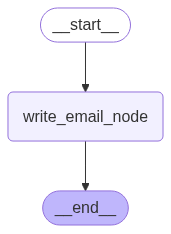

In [14]:
show_graph(app)

从图中可以清晰看出当前 graph 的流转形式是一个非常简单的直线流转 `Start -> write_email_node -> End`，其中 state 被更新一次。

在 LangGraph 中，节点间的流转也可以是[按条件执行](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)的。我们可以通过定义一个函数来实现这个功能，这个函数的返回值是图中节点的名字，你也可以自定义一个mapper来进行映射。

In [15]:
from typing import Literal
from langgraph.graph import MessagesState

In [16]:
def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state['messages'])
    return {"messages": [output]}

def run_tool(state: MessagesState) -> MessagesState:
    """Perform the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call['args'])
        result.append({
            "role": "tool",
            "content": observation,
            "tool_call_id": tool_call["id"]
        })

    return {"messages": result}

上述代码中定义了两个节点 `call_llm` 和 `run_tool`，其中有几点需要说明一下：
- `MessagesState` 是一个预定义的 `StateGraph` 的子类，其中包含 `messages` 字段，节点更新 `messages` 字段时，会自动 `extend` 初始数据，而不是 `override`；
- `run_tool` 中的临时变量 `observation` 很好的体现的 `tool` 的作用，**与环境交互，并返回交互的结果作为LLM对外部环境的观察**。

In [17]:
def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""

    # get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # If the last message is a tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

NODE_NAME_MAPPER = {
    "run_tool": "run_tool",
    END: END
}

上述代码中，我们定义了一个判断条件的函数，判断是否需要使用工具，并将其返回值映射到了对应的节点名称。需要注意的是，这里我们可以将 `END` 理解成和 `__end__` 是同一个内容。

最后，我们将这些节点通过edge串联起来。通过 `add_conditional_edges` 函数，将条件判断加入到graph中。

In [18]:
workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, NODE_NAME_MAPPER)
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

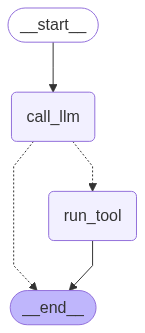

In [19]:
show_graph(app)

In [20]:
result = app.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "写一封邮件给张三，主题是关于项目进展，内容是：我们正在按照计划推进项目，预计下周完成。",

            }
        ]
    }
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

写一封邮件给张三，主题是关于项目进展，内容是：我们正在按照计划推进项目，预计下周完成。
================================== Ai Message ==================================
Tool Calls:
  write_email (call_bca981e51d954599bbabbe)
 Call ID: call_bca981e51d954599bbabbe
  Args:
    content: 我们正在按照计划推进项目，预计下周完成。
    subject: 项目进展
    to: 张三
================================= Tool Message =================================

邮件已发送给: 张三，主题为: 项目进展，内容为:
 我们正在按照计划推进项目，预计下周完成。


上面的内容主要介绍了 LangGraph 对 Workflows 和 Agents 的控制（Control）能力，让我们对如何使用 LangGraph 构建 Workflows 和 Agents 有了清晰的了解，更多的内容可以参考[官方文档](https://langchain-ai.github.io/langgraph/tutorials/workflows/)。

此外，为了方便构建 Agents，LangGraph 抽象出一个方法来方便开发人员快速构建agents。这个方法中，我们需要提供：
- LLM 作为大脑
- 一组工具
- Prompt 指令

In [22]:
from langgraph.prebuilt import create_react_agent
from src.agents_intro import llm

In [23]:
agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="使用提供的工具完成用户的请求",
)

# Run the agent
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "写一封邮件给张三，主题是关于项目进展，内容是：我们正在按照计划推进项目，预计下周完成。",
            }
        ]
    }
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

写一封邮件给张三，主题是关于项目进展，内容是：我们正在按照计划推进项目，预计下周完成。
================================== Ai Message ==================================
Tool Calls:
  write_email (call_efd27ad8b22a44bb92067f)
 Call ID: call_efd27ad8b22a44bb92067f
  Args:
    content: 我们正在按照计划推进项目，预计下周完成。
    subject: 项目进展
    to: 张三
================================= Tool Message =================================
Name: write_email

邮件已发送给: 张三，主题为: 项目进展，内容为:
 我们正在按照计划推进项目，预计下周完成。
================================== Ai Message ==================================

邮件已成功发送给张三，主题为“项目进展”，内容为：“我们正在按照计划推进项目，预计下周完成。”


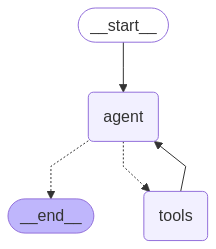

In [24]:
show_graph(agent)

可视化的agent图中，可以看出，agent的本质就是 LLM 借助 tools 与环境的循环交互。

![agent](img/agent.png)

## 持久化（Persistence）

LangGraph 提供了持久化功能，可以持久化存储图状态（State），使开发记忆功能（Memory）和人类干预功能（Human-in-the-loop）成为可能。

首先来理解持久化中的几个概念：
- `Thread`: 表示围绕一个特定主题展开的一系列相关讨论或消息的集合，即 “主题线索” 或 “讨论串”。在 LangGraph 中，thread 可以理解为一次任务执行过程中，所有状态的集合。
- `Checkpoint`: 表示在某个时间点，thread 的快照（snapshot），里面存储着当前节点的状态信息；
- `Super-step`: 任务执行过程中，每个顺序执行的节点被称为一个 super-step；

从下图中可以看出，快照（StateSnapshot）、Checkpoint、Super-step 是同一时间点的不同层次的概念表达。
> Checkpoint is a snapshot of the graph state saved at each super-step and is represented by StateSnapshot object.

![checkpointer](./img/checkpoints.png)

有了持久化的能力后，任何时间任何步骤的状态信息都可以被存储下来，这样，为我们后续 Agent 中的中断、回溯、恢复等一些列功能提供的基础。

`Checkpoint` 是 LangGraph 中持久化存储的抽象，它定义了如何将状态信息存储到内存中，或者存储到文件系统中。

LangGraph 中提供了多种 Checkpoint 的实现，包括：
- `InMemorySaver`: 将状态信息存储到内存中；
- `SqliteSaver`: 将状态信息存储到 SQLite 数据库中；
- `PostgresSaver`: 将状态信息存储到 PostgreSQL 数据库中；

接下来，我们使用 `InMemorySaver` 来介绍如何使用持久化功能。

create_react_agent 函数中，可以通过添加 `checkpointer` 参数来指定持久化存储的实现，对于自定义构建agent，可以使用 `graph = workflow.compile(checkpointer=InMemorySaver())` 来指定持久化存储的实现。




In [25]:
from langgraph.checkpoint.memory import InMemorySaver

In [26]:
agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="使用提供的工具完成用户的请求",
    checkpointer=InMemorySaver(),
)

config = {"configurable": {"thread_id": "1"}} # 指定当前 thread 的 id
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "给出一些写邮件的建议",
            }
        ]
    },
    config,
)

`get_state` 通过 `thread_id` 获取最新的状态，最新的state中，保留着所有的历史对话信息

In [27]:
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)

for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

给出一些写邮件的建议
================================== Ai Message ==================================

以下是一些撰写邮件的实用建议：

1. **主题明确**：
   - 邮件的主题要简洁明了，让收件人一眼就能看出邮件的主要内容或目的。

2. **称呼得当**：
   - 使用合适的称呼，例如“尊敬的XXX”、“亲爱的XXX”等，根据收件人的身份和关系选择恰当的称呼方式。

3. **内容清晰有条理**：
   - 邮件正文部分应逻辑清晰，分段落描述不同的内容点。可以使用项目符号或编号来增强可读性。
   - 保持语言简洁，避免冗长的句子和不必要的信息。

4. **语气礼貌友好**：
   - 即使是工作邮件，也要保持礼貌和尊重的语气。使用“您好”、“谢谢”、“请”等礼貌用语。

5. **检查拼写和语法错误**：
   - 在发送邮件之前，务必仔细检查拼写、语法和标点符号错误，确保邮件的专业性和准确性。

6. **签名完整**：
   - 邮件末尾要有署名，包括你的姓名、职位（如果是商务邮件）、公司名称以及联系方式（如电话号码、电子邮件地址等）。

7. **适当使用附件**：
   - 如果需要附上文件，请在邮件中提前说明，并在发送前确认附件是否已正确添加。

8. **注意隐私和安全**：
   - 不要在邮件中随意透露敏感信息，如身份证号、银行账户等。如果必须传递此类信息，建议通过加密或其他安全方式发送。

9. **合理使用抄送和密送**：
   - 抄送（CC）用于让其他人了解邮件内容，而密送（BCC）则用于保护收件人的隐私。根据实际情况选择是否需要使用这些功能。

10. **及时回复**：
    - 对收到的邮件应及时回复，尤其是对方有明确请求或截止日期的情况下。如果不方便立即处理，也可以先简单回复告知对方稍后会详细回应。

希望这些建议能帮助你写出更专业、有效的邮件！如果你有具体的场景或需求，我可以为你提供更详细的指导。


继续对话，新的对话内容会被添加到最新的state中

In [28]:
# 继续对话
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "很好，请使用第3条建议，给我的同事写一封信，告诉他项目进度一切正常。",
            }
        ]
    },
    config,
)
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

给出一些写邮件的建议
================================== Ai Message ==================================

以下是一些撰写邮件的实用建议：

1. **主题明确**：
   - 邮件的主题要简洁明了，让收件人一眼就能看出邮件的主要内容或目的。

2. **称呼得当**：
   - 使用合适的称呼，例如“尊敬的XXX”、“亲爱的XXX”等，根据收件人的身份和关系选择恰当的称呼方式。

3. **内容清晰有条理**：
   - 邮件正文部分应逻辑清晰，分段落描述不同的内容点。可以使用项目符号或编号来增强可读性。
   - 保持语言简洁，避免冗长的句子和不必要的信息。

4. **语气礼貌友好**：
   - 即使是工作邮件，也要保持礼貌和尊重的语气。使用“您好”、“谢谢”、“请”等礼貌用语。

5. **检查拼写和语法错误**：
   - 在发送邮件之前，务必仔细检查拼写、语法和标点符号错误，确保邮件的专业性和准确性。

6. **签名完整**：
   - 邮件末尾要有署名，包括你的姓名、职位（如果是商务邮件）、公司名称以及联系方式（如电话号码、电子邮件地址等）。

7. **适当使用附件**：
   - 如果需要附上文件，请在邮件中提前说明，并在发送前确认附件是否已正确添加。

8. **注意隐私和安全**：
   - 不要在邮件中随意透露敏感信息，如身份证号、银行账户等。如果必须传递此类信息，建议通过加密或其他安全方式发送。

9. **合理使用抄送和密送**：
   - 抄送（CC）用于让其他人了解邮件内容，而密送（BCC）则用于保护收件人的隐私。根据实际情况选择是否需要使用这些功能。

10. **及时回复**：
    - 对收到的邮件应及时回复，尤其是对方有明确请求或截止日期的情况下。如果不方便立即处理，也可以先简单回复告知对方稍后会详细回应。

希望这些建议能帮助你写出更专业、有效的邮件！如果你有具体的场景或需求，我可以为你提供更详细的指导。
================================ Human

可以通过 `get_state_history` 获取所有的state，最新的state在最前面。

In [29]:
# get all the states
states = agent.get_state_history(config)
for state in states:
    print(state.config)


{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04b-203f-60a8-8006-3ab2d0cb4200'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04b-0fba-6b24-8005-f3dd5d85c781'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04b-0fb5-64bc-8004-ccb3104f9f33'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04a-edab-6dc6-8003-a9aa95e42668'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04a-eda8-6356-8002-afddd264012b'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04a-b6fe-63dc-8001-78d430c87c81'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04a-4837-669c-8000-bc6e08cc7573'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03d04a-4833-62cc-bfff-a6f4e6290d08'}}


每个state的config中，都包含着 `thread_id` 和 `checkpoint_id` 信息。通过这两个字段，可以获取到某一个 super-step 的 state。

In [32]:
config_test = {
    "configurable": {
        "thread_id": "1",
        "checkpoint_id": "1f03d04a-4837-669c-8000-bc6e08cc7573", # 需要根据实际的 checkpoint_id 进行修改
    }
}
state_test = agent.get_state(config_test)
for message in state_test.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

给出一些写邮件的建议


### 中断（Interrupts）

有了持久化（Persistence）的能力后，我们就可以实现中断（Interrupts）功能。

中断功能，是指在任务执行过程中，当遇到某些条件时（比如等待用户反馈），可以暂停任务的执行，并保存当前的状态，等待后续恢复。



In [33]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state: State) -> State:
    print("-----Step 1-----")
    pass

def human_feedback(state: State) -> State:
    print("-----Human Feedback-----")
    feedback = interrupt("请输入你的反馈")
    return {"user_feedback": feedback}

def step_3(state: State) -> State:
    print("-----Step 3-----")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# set the checkpointer
memory = InMemorySaver()

# compile the graph
graph = builder.compile(checkpointer=memory)

上面的代码中，我们定义了3个node，分别是 `step_1`、`human_feedback`、`step_3`，其中 `human_feedback` 是一个中断节点，当执行到该节点时，会中断任务的执行，并等待用户输入反馈。

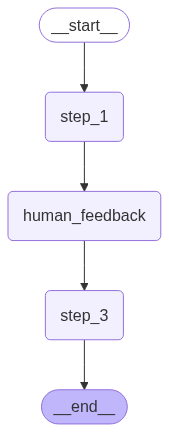

In [34]:
show_graph(graph)

`graph.stream` 是 LangGraph 中用于流式执行图的方法。它会按照定义的节点和边的顺序执行图，直到遇到中断点或结束。

下面代码中，`human_feedback` 节点中，我们定义了 `interrupt` 函数，当执行到该节点时，会中断任务的执行，并等待用户输入反馈。

In [35]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread_id = "2"
thread = {"configurable": {"thread_id": thread_id}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

-----Step 1-----
{'step_1': None}


-----Human Feedback-----
{'__interrupt__': (Interrupt(value='请输入你的反馈', resumable=True, ns=['human_feedback:8319ab8d-a6c3-3962-3142-28df29803e9d']),)}




LangGraph 中，提供了一个功能强大的 `Command` 对象，可以将状态更新与流程控制结合起来。

这里，我们可以用 `Command` 来接收用户输入，并恢复图的执行。

In [36]:
human_input = input("请输入你的反馈")

# Continue the graph execution
for event in graph.stream(Command(resume=human_input), thread, stream_mode="updates"):
    print(event)
    print("\n")

-----Human Feedback-----
{'human_feedback': {'user_feedback': 'hello'}}


-----Step 3-----
{'step_3': None}




注意，上面的这块代码只能执行一次，因为整个图已经执行完了。如果想要多次执行，需要重新初始化图。

最后，让我们看一下整体的 state 信息。

In [37]:
last_state = graph.get_state(thread)
print(last_state.values)

{'input': 'hello world', 'user_feedback': 'hello'}


### 总结

通过上面的内容，我们了解了 LangGraph 的持久化（Persistence）和中断（Interrupts）功能。

持久化功能，可以让我们在任务执行过程中，将状态信息存储下来，并恢复到任意一个时间点。

中断功能，可以让我们在任务执行过程中，当遇到某些条件时，可以暂停任务的执行，并等待用户输入反馈。

## 跟踪（Tracking）

LangChain 生态中，可以使用 LangSmith 来追踪所有的 LangGraph 的执行过程。

需要设置三个环境变量：
- `LANGSMITH_TRACING=true`
- `LANGSMITH_API_KEY=<your-api-key>`，需要从 [LangSmith](https://smith.langchain.com/) 获取
- `LANGSMITH_PROJECT="<your-project-name>"`，可选。

![langsmith](./img/lang_smith_demo.png)



